# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [ ]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
# List all files/folders in MyDrive
print(os.listdir("/content/MyDrive"))

['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Check root of MyDrive
print(os.listdir("/content/drive"))

['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


In [ ]:
image_dir = "/content/drive/MyDrive/realwaste-main/RealWaste/"
description_file = "/content/waste_descriptions.csv"
policy_file = "/content/waste_policy_documents.json"

In [ ]:
categories = os.listdir(image_dir)
print("Waste categories:", categories)

Waste categories: ['Plastic', 'Miscellaneous Trash', 'Textile Trash', 'Vegetation', 'Food Organics', 'Glass', 'Cardboard', 'Metal', 'Paper']


Sample descriptions:


,description,category,disposal_instruction,common_confusion,material_composition
0,soiled silver tablecloth,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
1,folded glass bottle leaking,Glass,"Remove caps, lids, and corks before recycling.",NaN,"Silica-based material, may contain additives f..."
2,large Supermarket vegetable waste with food re...,Food Organics,"If no compost available, place in general waste.",NaN,Biodegradable matter derived from plant or ani...
3,intact floral carpet piece,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
4,empty fun-sized purple apple core,Food Organics,Keep separate from recyclable materials.,Meat and dairy products may be restricted in s...,Biodegradable matter derived from plant or ani...


Sample policy document:
{
  "policy_id": 1,
  "policy_type": "Textile Trash Recycling Guidelines",
  "categories_covered": [
    "Textile Trash"
  ],
  "effective_date": "2023-11-04",
  "document_text": "TEXTILE RECYCLING GUIDELINES\n\nAcceptable Items:\n- Clean clothing (all conditions)\n- Towels, sheets, and linens\n- Fabric scraps\n- Curtains and cloth napkins\n- Handbags and backpacks made of fabric\n- Soft toys and stuffed animals\n\nNon-Acceptable Items:\n- Wet or moldy textiles\n- Heavily soiled items\n- Carpets and rugs\n- Footwear\n- Items with significant non-textile parts\n\nCollection Method:\nPlace items in dedicated textile recycling bins or donate to local thrift stores.\n\nPreparation Instructions:\n- Ensure all items are clean and dry\n- Remove non-textile components when possible\n- Bag similar items together\n\nBenefits:\nTextile recycling conserves resources and reduces landfill waste.",
  "jurisdiction": "Metro City"
}
Waste categories: ['Plastic', 'Miscellaneous T

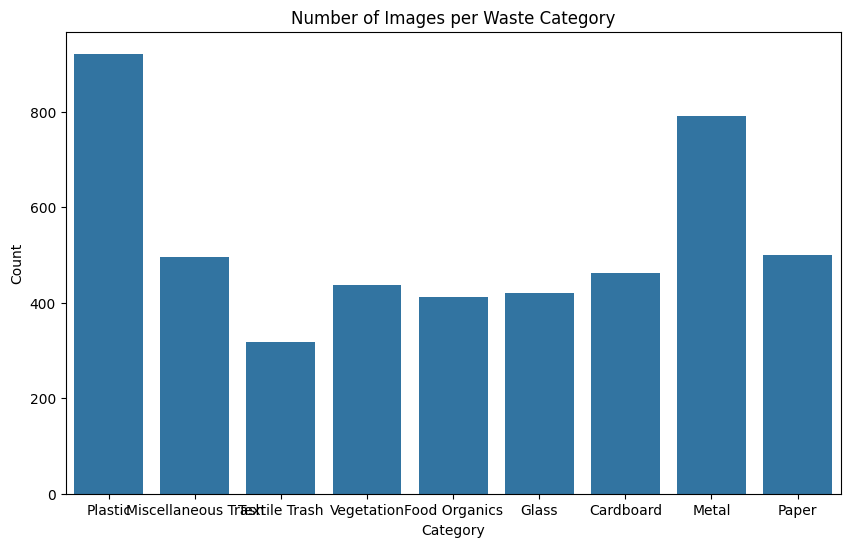

Category: Plastic, Image: Plastic_609.jpg, Size: (524, 524), Mode: RGB


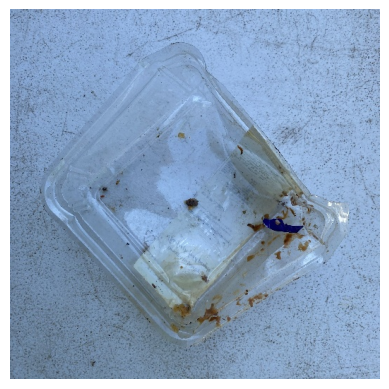

Category: Miscellaneous Trash, Image: Miscellaneous Trash_153.jpg, Size: (524, 524), Mode: RGB


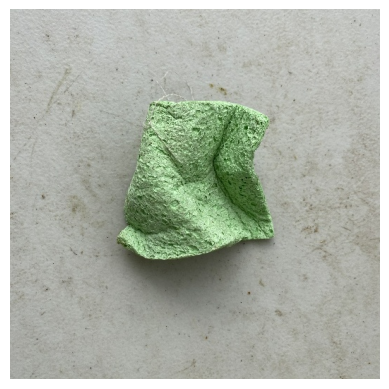

Category: Textile Trash, Image: Textile Trash_90.jpg, Size: (524, 524), Mode: RGB


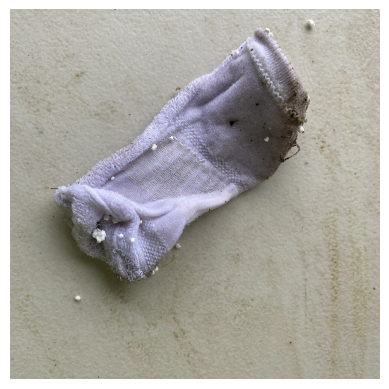

In [ ]:
# Paths
image_dir = "/content/drive/MyDrive/realwaste-main/RealWaste/"
description_file = "/content/waste_descriptions.csv"
policy_file = "/content/waste_policy_documents.json"

# Load text descriptions
descriptions_df = pd.read_csv(description_file)
print("Sample descriptions:")
display(descriptions_df.head())

# Load policy documents
with open(policy_file, 'r') as f:
    policies = json.load(f)
print("Sample policy document:")
print(json.dumps(policies[0], indent=2))

# Explore image dataset
categories = os.listdir(image_dir)
categories = [cat for cat in categories if os.path.isdir(os.path.join(image_dir, cat))]
print("Waste categories:", categories)

# Count images per category
category_counts = {cat: len(os.listdir(os.path.join(image_dir, cat))) for cat in categories}
plt.figure(figsize=(10,6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title("Number of Images per Waste Category")
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

# Sample images inspection
for cat in categories[:3]:  # just sample first 3 categories
    sample_img_name = os.listdir(os.path.join(image_dir, cat))[0]
    img = Image.open(os.path.join(image_dir, cat, sample_img_name))
    print(f"Category: {cat}, Image: {sample_img_name}, Size: {img.size}, Mode: {img.mode}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### 1.2 Explore Text Datasets

First 5 rows of waste_descriptions.csv:
                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                           

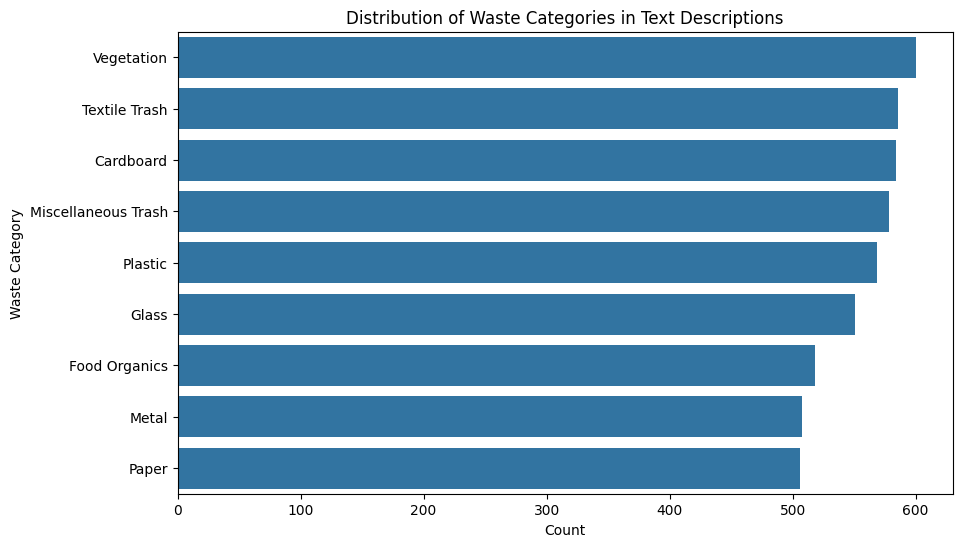

Total number of waste descriptions: 5000
Average description length (words): 4.85
Approximate vocabulary size: 305
Top 20 most common words:
[('with', 727), ('glass', 424), ('empty', 348), ('bottle', 342), ('food', 316), ('paper', 316), ('box', 313), ('residue', 309), ('plastic', 251), ('brand', 247), ('metal', 241), ('dry', 211), ('new', 196), ('soiled', 189), ('crumpled', 189), ('medium', 187), ('orange', 186), ('stained', 185), ('intact', 184), ('broken', 184)]


In [ ]:
# Load CSV
descriptions_df = pd.read_csv(description_file)

# Quick look at the data
print("First 5 rows of waste_descriptions.csv:")
print(descriptions_df.head())

# Info about columns and missing values
print("\nDataFrame info:")
print(descriptions_df.info())

# Check for missing values
print("\nMissing values per column:")
print(descriptions_df.isnull().sum())


plt.figure(figsize=(10,6))
sns.countplot(y='category', data=descriptions_df, order=descriptions_df['category'].value_counts().index)
plt.title("Distribution of Waste Categories in Text Descriptions")
plt.xlabel("Count")
plt.ylabel("Waste Category")
plt.show()


num_descriptions = len(descriptions_df)
print(f"Total number of waste descriptions: {num_descriptions}")

# Average length of descriptions (in words)
descriptions_df['text_length'] = descriptions_df['description'].apply(lambda x: len(str(x).split()))
avg_length = descriptions_df['text_length'].mean()
print(f"Average description length (words): {avg_length:.2f}")

# Vocabulary size (approximate)
from collections import Counter
all_words = ' '.join(descriptions_df['description'].astype(str)).lower().split()
vocab = Counter(all_words)
print(f"Approximate vocabulary size: {len(vocab)}")

# Most common words
print("Top 20 most common words:")
print(vocab.most_common(20))


Total number of policy documents: 14

Sample policy document (formatted):
{
  "policy_id": 1,
  "policy_type": "Textile Trash Recycling Guidelines",
  "categories_covered": [
    "Textile Trash"
  ],
  "effective_date": "2023-11-04",
  "document_text": "TEXTILE RECYCLING GUIDELINES\n\nAcceptable Items:\n- Clean clothing (all conditions)\n- Towels, sheets, and linens\n- Fabric scraps\n- Curtains and cloth napkins\n- Handbags and backpacks made of fabric\n- Soft toys and stuffed animals\n\nNon-Acceptable Items:\n- Wet or moldy textiles\n- Heavily soiled items\n- Carpets and rugs\n- Footwear\n- Items with significant non-textile parts\n\nCollection Method:\nPlace items in dedicated textile recycling bins or donate to local thrift stores.\n\nPreparation Instructions:\n- Ensure all items are clean and dry\n- Remove non-textile components when possible\n- Bag similar items together\n\nBenefits:\nTextile recycling conserves resources and reduces landfill waste.",
  "jurisdiction": "Metro City

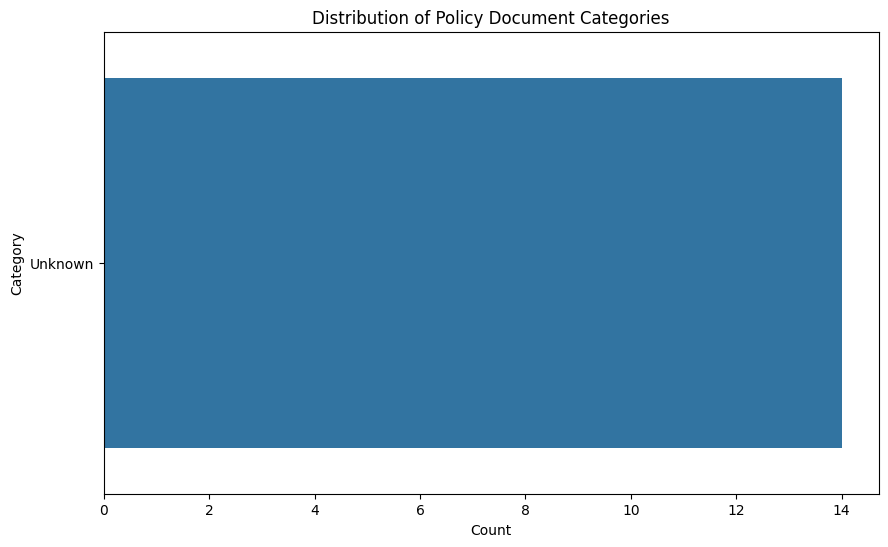

Average length of policy content (words): 0.00
Minimum content length: 0, Maximum: 0

Policy excerpts:

Document 1 excerpt:  ...

Document 2 excerpt:  ...

Document 3 excerpt:  ...


In [ ]:
import json

with open(policy_file, 'r') as f:
    policies = json.load(f)

# Number of documents
print(f"Total number of policy documents: {len(policies)}")

# Preview the first document
print("\nSample policy document (formatted):")
print(json.dumps(policies[0], indent=2))


#  Understand document structure

# Assuming each policy document is a dictionary with keys like 'title', 'content', 'category', etc.
keys = set()
for doc in policies:
    keys.update(doc.keys())
print("\nAll keys present in policy documents:", keys)

# Check distribution of categories (if 'category' key exists)
categories = [doc.get('category', 'Unknown') for doc in policies]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cat_df = pd.DataFrame({'category': categories})
plt.figure(figsize=(10,6))
sns.countplot(y='category', data=cat_df, order=cat_df['category'].value_counts().index)
plt.title("Distribution of Policy Document Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


#  Analyze text length and content

# Example: length of content in words
content_lengths = [len(doc.get('content','').split()) for doc in policies]
print(f"Average length of policy content (words): {sum(content_lengths)/len(content_lengths):.2f}")
print(f"Minimum content length: {min(content_lengths)}, Maximum: {max(content_lengths)}")

# Optionally, print a short excerpt from first few documents
print("\nPolicy excerpts:")
for i, doc in enumerate(policies[:3]):
    content = doc.get('content','')
    print(f"\nDocument {i+1} excerpt:", content[:300], "...")


### 1.3 Create Data Pipelines

In [ ]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/realwaste-main/RealWaste")

#data_dir = pathlib.Path('RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [ ]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here

In [ ]:
descriptions_df = pd.read_csv(description_file)
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Quick check
print(descriptions_df.head())


#  Text cleaning function

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

descriptions_df['cleaned_description'] = descriptions_df['description'].apply(clean_text)


#  Encode labels

# Create a mapping from category names to integers
category_list = sorted(descriptions_df['category'].unique())
category_to_index = {cat:i for i, cat in enumerate(category_list)}
descriptions_df['label'] = descriptions_df['category'].map(category_to_index)

num_classes = len(category_list)
print(f"Number of categories: {num_classes}")
print("Category mapping:", category_to_index)


#  Tokenization & padding

MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 50  # max words per description

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(descriptions_df['cleaned_description'])

sequences = tokenizer.texts_to_sequences(descriptions_df['cleaned_description'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Example sequence (padded):")
print(padded_sequences[0])


# Train-test split

X = padded_sequences
y = tf.keras.utils.to_categorical(descriptions_df['label'], num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


# create TensorFlow dataset

BATCH_SIZE = 32

train_ds_text = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_text = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3           

In [ ]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# Your code here

In [ ]:
#  Imports

import json
import re
from sentence_transformers import SentenceTransformer
import numpy as np
import pickle


# 2 Load policy documents

with open(policy_file, 'r') as f:
    policies = json.load(f)


# 3 Preprocess text
# - lowercase, remove extra spaces, remove non-alphanumeric chars

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces/newlines
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special characters
    return text.strip()

# Combine title + content for each document
documents = []
for doc in policies:
    content = doc.get('document_text', '') # Use 'document_text' key
    clean_text = preprocess_text(content)
    documents.append(clean_text)

print(f"Total documents processed: {len(documents)}")
print("Sample processed document:", documents[0][:300], "...")


# 4️ Split documents into smaller chunks for retrieval

CHUNK_SIZE = 150  # words per chunk
doc_chunks = []

for doc in documents:
    words = doc.split()
    for i in range(0, len(words), CHUNK_SIZE):
        chunk = " ".join(words[i:i+CHUNK_SIZE])
        doc_chunks.append(chunk)

print(f"Total chunks created: {len(doc_chunks)}")
if len(doc_chunks) > 0:
  print("Sample chunk:", doc_chunks[0])
else:
  print("No chunks created.")


# Create embeddings

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast

# Generate embeddings
embeddings = model.encode(doc_chunks, show_progress_bar=True)
embeddings = np.array(embeddings)

print("Embeddings shape:", embeddings.shape)


#  Save chunks and embeddings (optional)

with open("policy_chunks.pkl", "wb") as f:
    pickle.dump(doc_chunks, f)

with open("policy_embeddings.npy", "wb") as f:
    np.save(f, embeddings)

print("Chunks and embeddings saved successfully.")

Total documents processed: 14
Sample processed document: textile recycling guidelines acceptable items  clean clothing all conditions  towels sheets and linens  fabric scraps  curtains and cloth napkins  handbags and backpacks made of fabric  soft toys and stuffed animals nonacceptable items  wet or moldy textiles  heavily soiled items  carpets and rugs   ...
Total chunks created: 14
Sample chunk: textile recycling guidelines acceptable items clean clothing all conditions towels sheets and linens fabric scraps curtains and cloth napkins handbags and backpacks made of fabric soft toys and stuffed animals nonacceptable items wet or moldy textiles heavily soiled items carpets and rugs footwear items with significant nontextile parts collection method place items in dedicated textile recycling bins or donate to local thrift stores preparation instructions ensure all items are clean and dry remove nontextile components when possible bag similar items together benefits textile recycling cons

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (14, 384)
Chunks and embeddings saved successfully.


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

import tensorflow as tf

# Assuming you already created train_ds, validation_ds, and test_dataset previously

# 1️⃣ Normalize pixel values
# CNNs train better when pixel values are in [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# 2️⃣ (Optional) Data augmentation
# Helps prevent overfitting and improves generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply augmentation only to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 3️⃣ Optimize pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Confirm preprocessing
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


### 2.2 Implement CNN Model with Transfer Learning

In [ ]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Import necessary modules
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Number of waste classes (you can update if needed)
NUM_CLASSES = len(class_names)  # or manually set to 9

# 1️⃣ Choose a pretrained base model
# EfficientNetB0 is light, accurate, and ideal for image classification tasks
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # exclude final dense layers
    weights='imagenet'
)

# Freeze the base model to retain pretrained ImageNet features
base_model.trainable = False

# 2️⃣ Build the transfer learning model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Preprocessing layer (EfficientNet expects specific input scaling)
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

# Pass through base model
x = base_model(x, training=False)

# Global average pooling to reduce dimensions
x = layers.GlobalAveragePooling2D()(x)

# Optional dropout for regularization
x = layers.Dropout(0.3)(x)

# Final classification layer (softmax for multi-class)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Define model
model = tf.keras.Model(inputs, outputs)

# 3️⃣ Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 2.3 Train and Evaluate the Model

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.1797 - loss: 2.1862 - val_accuracy: 0.2064 - val_loss: 2.1398 - learning_rate: 0.0010
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.1740 - loss: 2.1708 - val_accuracy: 0.2064 - val_loss: 2.1591 - learning_rate: 0.0010
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1702 - loss: 2.1702
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
119/119 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.1702 - loss: 2.1702 - val_accuracy: 0.2064 - val_loss: 2.1662 - learning_rate: 0.0010
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.1933 - loss: 2.1687 - val_accuracy: 0.2064 - val_loss: 2.1352 - learning_rate: 2.0000e-04
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.1728 - loss: 2.1643 - val_accuracy: 0.2064 - val_loss: 2.1411 - learning_rate: 2.0000e-04
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1879 - loss

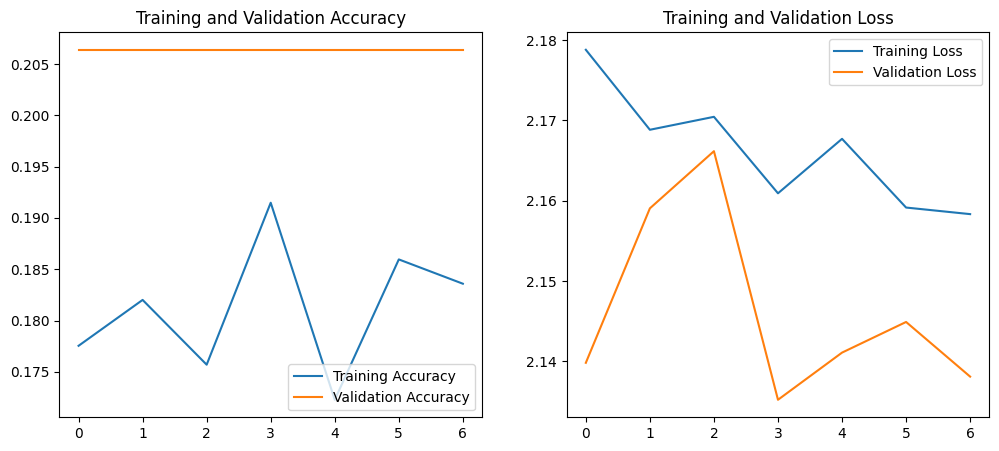

In [ ]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1️⃣ Training configuration
EPOCHS = 15
BATCH_SIZE = 32

# Early stopping and learning rate scheduling to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 2️⃣ Train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 3️⃣ Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# 4️⃣ Visualize training performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [1]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ Evaluate accuracy on test set
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# 2️⃣ Generate predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 3️⃣ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Waste Classification')
plt.show()

# 4️⃣ Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5️⃣ Analyze common misclassifications
misclassified_indices = np.where(y_true != y_pred)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")

# Optional: visualize a few misclassified examples
for images, labels in test_dataset.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)

    mis_idx = np.where(pred_labels != true_labels)[0]
    print(f"Displaying {len(mis_idx)} misclassified examples from this batch...")

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(mis_idx[:6]):  # show up to 6 examples
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.show()

NameError: name 'model' is not defined

### 2.4 Fine-tune the Model

In [3]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# 1️⃣ Unfreeze top layers of the base model for fine-tuning
base_model.trainable = True

# Optionally, freeze most layers and only fine-tune the top ones
fine_tune_at = int(len(base_model.layers) * 0.7)  # unfreeze top 30%
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 2️⃣ Re-compile with a lower learning rate (important for fine-tuning)
fine_tune_lr = 1e-5
model.compile(
    optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Add regularization and dropout if not already present
# (You can rebuild the classifier head with dropout/regularization if needed)
# The model architecture is already defined in cell H6HPFM1mRjNa.
# We will fine-tune the existing 'model' object directly after unfreezing layers.

# 4️⃣ Callbacks for stable training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 5️⃣ Train the fine-tuned model
history_fine = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# 6️⃣ Evaluate after fine-tuning
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f"\n✅ Fine-tuned Test Accuracy: {test_acc:.4f}")
print(f"✅ Fine-tuned Test Loss: {test_loss:.4f}")

NameError: name 'base_model' is not defined

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
descriptions_df = pd.read_csv("/content/drive/MyDrive/waste_descriptions.csv")
print("✅ Data loaded successfully!")
print(descriptions_df.head())

# 1️⃣ Clean text function
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

# Apply cleaning
descriptions_df['cleaned_description'] = descriptions_df['description'].apply(clean_text)

# 2️⃣ Prepare labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
descriptions_df['label_encoded'] = label_encoder.fit_transform(descriptions_df['category'])
num_classes = len(label_encoder.classes_)
print(f"✅ Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

# 3️⃣ Tokenization
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(descriptions_df['cleaned_description'])

# Convert text to sequences and pad
sequences = tokenizer.texts_to_sequences(descriptions_df['cleaned_description'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# 4️⃣ Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    descriptions_df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=descriptions_df['label_encoded']
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# 5️⃣ Example check
print("\nExample cleaned + tokenized text:")
print(descriptions_df[['description', 'cleaned_description']].head(3))

### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

#optionA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.4

# Build the model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=EMBEDDING_DIM, input_length=50),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
    Dropout(DROPOUT_RATE),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Summary
lstm_model.summary()

# Train
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=32,
    verbose=1
)

# Evaluate
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")


### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Training parameters
EPOCHS = 10
BATCH_SIZE = 32

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# Plot training history


plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Classification report
target_names = label_encoder.classes_
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — Waste Description Classifier (LSTM)")
plt.show()

# Error analysis — show top misclassified examples
mismatch_indices = np.where(y_test != y_pred)[0]
print(f"\n❌ Misclassified examples: {len(mismatch_indices)} / {len(y_test)}")

# Show a few examples
for i in mismatch_indices[:5]:
    print(f"\n🗑️ Description: {descriptions_df.iloc[i]['description']}")
    print(f"Predicted: {target_names[y_pred[i]]} | Actual: {target_names[y_test.iloc[i]]}")

### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    pass

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Your code here

### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

# Your code here

### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Your code here

In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here

### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    pass

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    pass

### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.